# Recipe Popularity Predictor

## Executive Summary

#### Objective
The purpose of this project was to develop a predictive model to identify popular recipes for the homepage with at least 80% accuracy. This was aimed at improving website traffic and subscription rates by optimizing recipe selection.  

#### Key Steps Taken
1. **Data Validation and Cleaning:**  
   - Validated and cleaned the raw data by addressing missing values and formatting issues to ensure consistency and usability.
2. **Exploratory Data Analysis (EDA) and Feature Engineering:**  
   - Conducted detailed analysis to identify key features influencing recipe popularity. This included visualizing data distributions and evaluating relationships between key variables.
   - Used insights from EDA to create new features to enrich the dataset.
3. **Model Development and Evaluation:**  
   - Built and tested machine learning models, including Logistic Regression and Random Forest, using both single and multiple features.
   - Performed hyperparameter tuning to improve the model performance and optimize predictive accuracy.
   - Evaluated models using metrics such as accuracy and f1-score as metrics.
4. **Communication of Insights**:
   - Key insights were documented at the end of each section and conclusions drawn.

#### Key Findings
- Exploratory Data Analysis (EDA) showed that recipe category is the strongest predictor of recipe popularity. Using only the category as a feature achieved 77.89% accuracy in both the Logistic Regression and Random Forest models. Additional features, while potentially useful, introduced noise that slightly reduced model performance. The final selected model, however, was a Logistic Regression model with multiple features (76.84% accuracy).
- Certain recipe categories, such as Vegetables, Pork, and Potatoes, consistently generate high traffic. On the other hand, categories like Beverages, Chicken, and Breakfast attract significantly lower traffic.
- Recipes flagged as outliers based on their nutritional information do not need to be removed.
- Model development efforts demonstrated that popular recipes can indeed be systematically identified, reducing the reliance on subjective personal preferences.

#### Recommendations  
1. **Prioritize High-Traffic Recipe Categories:** The business should focus on displaying recipe categories like Vegetables, Pork, Potatoes, and Meat on the homepage. These categories likely appeal to a broad audience, potentially including those with dietary restrictions (e.g., vegetarian options), due to factors such as simplicity, accessibility, or general popularity. While the exact reasons for their performance are unclear due to limited feature data, their high traffic warrants prioritization.
2. **Perform Feature Analysis of Top Categories:** Analyze high-performing recipe categories by examining attributes such as preparation time, cost, user ratings, and ingredient count (where available). This analysis will offer actionable insights into the factors driving their popularity, enabling better-targeted recommendations.
3. **Enhance Data Collection and Quality:** Increase the volume and variety of data collected for each recipe, such as preparation complexity, ingredient sourcing, preparation time. Efficient data collection mechanisms should also be implemented to minimize missing data, as gaps can impact the accuracy and robustness of modeling efforts.
4. **Incorporate Findings into Business Strategy:** Insights from this project should be used to inform decision-making and optimize recipe visibility strategies while fine-tuning modeling efforts.

## 1. Introduction
Tasty Bytes, founded in 2020 during the Covid-19 pandemic, began as a recipe search engine to help people make the most of limited ingredients. Today, the company has evolved into a subscription-based service, offering personalized meal plans to ensure families enjoy healthy, balanced diets within their budgets. Premium subscribers also benefit from doorstep delivery of ingredients.

The product team has identified an opportunity to enhance user engagement and increase subscriptions by optimizing recipe selection for the website homepage.

### 1.1 Problem Statement
The current approach to selecting recipes for the homepage is inconsistent and relies on personal preference, which leads to variable traffic results. While popular recipes can increase website traffic by up to 40% and directly impact subscription rates, there isn't yet a systematic way to predict which recipes will perform well. This makes it difficult to maximize engagement and conversions.

### 1.2 Business Objective
The objective here is to **develop a predictive model** that identifies popular recipes with at least 80% accuracy while also minimizing the likelihood of displaying unpopular ones. This will help improve recipe selection for the homepage, maximize website traffic, and ultimately drive subscription growth.

This report outlines the analysis, predictive modeling, and actionable recommendations to support this business objective.

### 1.3 Libraries and Configurations
In this analysis, we will use the following libraries:

- `Pandas` for data manipulation.
- `NumPy` and `SciPy` for numerical operations.
- `Matplotlib` and `Seaborn` for data visualization.
- `Scikit-learn` for machine learning models and evaluation.

In [1]:
!pip install category_encoders

In [2]:
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, zscore
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold

## 2. Data Preparation and Validation
The goal here is to develop some understanding of the data we'll be using. We shall examine the structure of the data and types of variables that we have been provided, and we'll also check for missing or duplicate observations.

### 2.1. Data Overview
For now, this is what we have from the product manager, which we will need to validate.
| Column | Description
|----------|----------
| recipe    | Numeric, unique identifier of the recipe  
| calories    | Numeric, number of calories  
| carbohydrate   | Numeric, amount of carbohydrates in grams   
| sugar | Numeric, amount of sugar in grams
| protein    | Numeric, amount of protein in grams  
| category    |Character, type of recipe. Recipes are listed in one of ten possible groupings
| servings   | Numeric, number of servings for the recipe
| high_traffic | Character, "High" if the traffic to the site was high when the said recipe was shown

In [3]:
recipe = pd.read_csv('recipe_site_traffic_2212.csv')
display(recipe.sample(5))

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
123,124,38.92,12.90,11.32,69.53,Chicken Breast,1,NaN
624,625,68.54,7.55,17.68,0.93,Beverages,4,NaN
501,502,883.12,70.81,6.85,94.00,Chicken,6,NaN
257,258,575.07,69.94,1.18,1.80,Vegetable,1,High
916,917,64.27,0.16,51.64,0.74,Beverages,2,NaN


### 2.2. Data Validation

#### Check for number of observations and column data types
We have over 900 recipes with 8 columns. We quickly find that the "servings" column does not have the right data type when compared with the information provided by the product manager. There are 947 unique recipes (as an identifier, recipe can be dropped). There are also lots of missing data, but we will address this later.

In [4]:
recipe.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)

#### Check for the kinds of servings
The unique servings are indeed a mix of integers and strings, which is why the column has been encoded as an object.

In [5]:
recipe['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

The extra information, "as a snack", is redundant since observations with this extra information occur only for the "Lunch/Snacks" category. In other words, this insight has already been captured in the category column.

In [6]:
recipe[recipe['servings'].isin(['4 as a snack', '6 as a snack'])]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


#### Check for missingness
While the calories and nutrients columns each have 52 missing values, the target column, "high_traffic" has more than seven times this number of missing values. Thus, there are two concerns to examine further here:
* Missing values in high_traffic
* Missing values for the calories, carbohydrate, sugar, and protein.

In [7]:
recipe.isna().sum().sort_values()

,0
recipe,0
category,0
servings,0
calories,52
carbohydrate,52
sugar,52
protein,52
high_traffic,373


Indeed, the large number of missing values in "high_traffic" may be due to how the column has been categorized. Unpopular ("Low") recipes are not desired, as such, no effort is made to enter the corresponding value of high_traffic. For the sake of this analysis, we will therefore assume that missing "high_traffic" points to an unpopular ("Low") recipe.

In [8]:
recipe['high_traffic'].unique()

array(['High', nan], dtype=object)

We earlier highlighted that four columns (calories, carbohydrate, sugar, and protein) have the same number of missing values (52). Interestingly, all these missing values occur together, which suggests that there is some underlying reason for their absence that might be related to other variables. This is a case of data being **Missing At Random**.

In [9]:
missing_info = recipe.loc[recipe[['calories', 'carbohydrate', 'sugar', 'protein']].isnull().all(axis=1)]
if len(missing_info) == 52:
    print('All the data are missing together.')
else:
    print('Not all the data are missing together')
missing_info.tail()

All the data are missing together.


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
896,897,NaN,NaN,NaN,NaN,Chicken,6,High
911,912,NaN,NaN,NaN,NaN,Dessert,6,High
918,919,NaN,NaN,NaN,NaN,Pork,6,High
938,939,NaN,NaN,NaN,NaN,Pork,4,High
943,944,NaN,NaN,NaN,NaN,Potato,2,High


This patterned missingness occurs for all categories **except** Beverages and Breakfast. Meanwhile, there are actually 11 unique recipe categories, as opposed to 10 which was expected. The separation of "Chicken Breast" and "Chicken" is the reason for this discrepancy.

In [10]:
# check if this patterned missingness occurs for all recipe categories
set(recipe['category'].unique()).difference(missing_info['category'].unique())

{'Beverages', 'Breakfast'}

In [11]:
recipe['category'].value_counts().sort_index()

,count
category,
Beverages,92
Breakfast,106
Chicken,74
Chicken Breast,98
Dessert,83
Lunch/Snacks,89
Meat,79
One Dish Meal,71
Pork,84


We can leave the "Chicken" and "Chicken Breast" as separate categories, or we could combine them. If we leave both as separate categories, we'd find that both categories generally have a higher proportion of low traffic recipes; although the difference in the number of high traffic and low traffic recipes is smaller with chicken breasts.

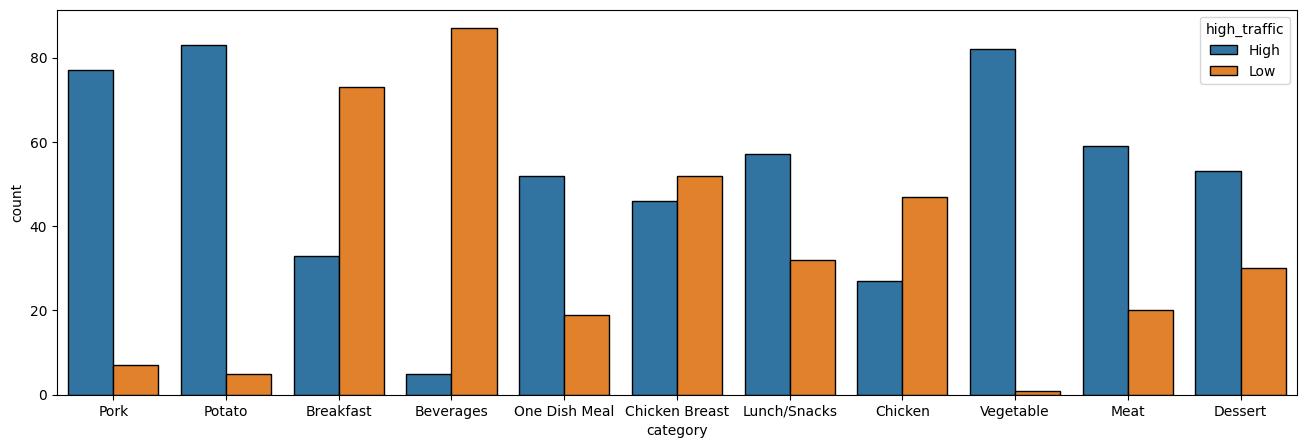

In [12]:
recipe['high_traffic'] = recipe['high_traffic'].fillna("Low")

plt.figure(figsize=(16, 5))
sns.countplot(data=recipe, x='category', hue='high_traffic', edgecolor='black')
plt.show();

Now, we were to combine both categories, the plot below is what we would have.

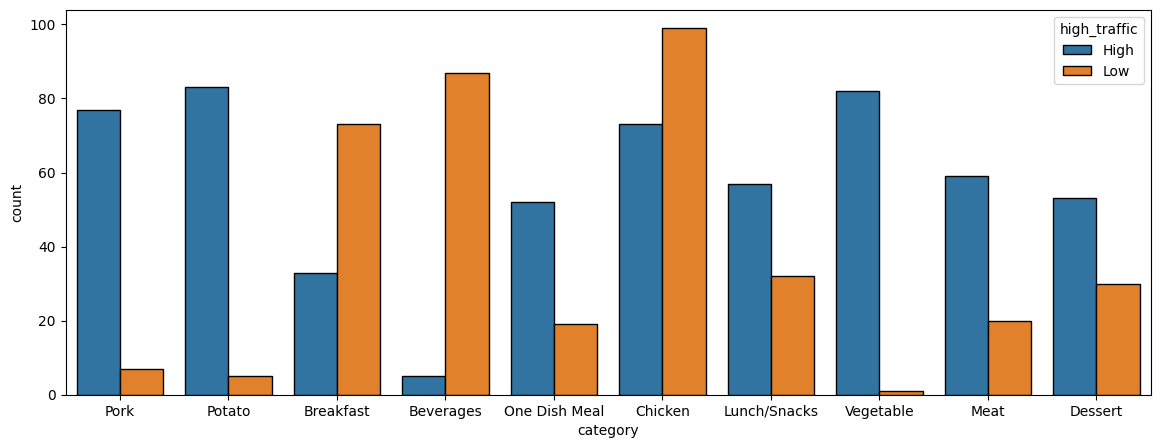

In [13]:
chicken_combined = recipe.copy()
chicken_combined['category'] = chicken_combined['category'].str.replace(' Breast', '')

plt.figure(figsize=(14, 5))
sns.countplot(data=chicken_combined, x='category', hue='high_traffic', edgecolor='black')
plt.show();

#### Check for data range: numeric variables

In [14]:
recipe.select_dtypes('number').describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


#### Summary of Findings
1. The `recipe` is merely an identifier and can be dropped.
2. The `servings` column has an incorrect data type (object) that should be converted to float.
3. Missing values in `high_traffic` correspond to unpopular recipes ("Low" traffic). These will be replaced with "Low."
4. Missing values for calories and nutritional data are **Missing At Random (MAR)**, thus allowing for imputation using other variables.
5. The dataset contains 11 recipe categories instead of the expected 10. This discrepancy is due to the separation of "Chicken" and "Chicken Breast." Since both categories generally have similar distributions of high and low traffic recipes, it might be helpful to combine them.
6. Numeric variables have appropriate ranges. Although the ranges are very different. Standardisation techniques will be required when using machine learning algorithms that are impacted by data ranges.

### 2.3. Data Cleaning
All cleaning tasks will be consolidated into a single function below to allow for efficient data preprocessing. Besides basic cleaning of the data, this function also includes the following:
1. An option for handling the missing calorific and nutrient information either through KNN imputation or by using the mean or median values grouped by the recipe categories.
2. An option to remove outliers using their zscores, depending on what task is being performed and if removing them would actually help the downstream model.

In [15]:
def clean_recipe(data, impute_by=None, remove_outliers=False):
    """
    A function to clean the recipe data. Missing values for the calories and nutrients can be done using either a KNNImputer
    (impute_by=knn) or by grouping the data by category and imputing using the mean (impute_by=category)

    Args:
      data: pd.DataFrame
      impute_by: str (Default value = None)

    Returns: pd.DataFrame

    """

    data = data.copy()

    # drop recipe column
    data = data.drop(columns='recipe')

    # convert servings data type
    data['servings'] = data['servings'].str.strip('as a snack').astype('int32')

    # replace missing high_traffic with "Low"
    data['high_traffic'] = data['high_traffic'].fillna("Low")

    # combine chicken breast and chicken into one category "Chicken"
    data['category'] = data['category'].str.replace(' Breast', '')

    if impute_by in ['category_mean', 'category_median']:
        # Group by category and calculate the mean for each group
        group_stat = data.groupby(by='category')\
                          [['calories', 'carbohydrate', 'sugar', 'protein']]\
                          .transform(impute_by.split('_')[-1])

        # Use the stat to fill missing values in the original dataframe
        data.iloc[:, 0:4] = data.iloc[:, 0:4].fillna(group_stat)

    if remove_outliers:
        # columns with outliers
        columns_with_out = ['carbohydrate', 'sugar', 'protein', 'calories']

        # Calculate Z-scores for the specified columns
        z_scores = data[columns_with_out].apply(zscore)

        # Define outliers as rows where the absolute Z-score is greater than 2 in any of the specified columns
        outliers = (z_scores.abs() > 2).any(axis=1)

        # Data without outliers
        data = data[~outliers]

    return data

## 3. Exploratory Data Analysis (EDA)
For this analysis, we will work with a cleaned data whose missing data has been imputed using the median. The outliers are not handled.

In [16]:
df = clean_recipe(recipe, impute_by='category_median', remove_outliers=False)

In [17]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,399.26,19.56,5.23,29.82,Pork,6,High
1,35.48,38.56,0.66,0.92,Potato,4,High
2,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,97.03,30.56,38.63,0.02,Beverages,4,High
4,27.05,1.85,0.80,0.53,Beverages,4,Low


#### Distribution of individual variables

Let's begin by exploring the distributions of individual features in the data. We'd begin with the target variable. As shown below, there are more high traffic recipes than low traffic ones, but the distribution is not severely imbalanced.

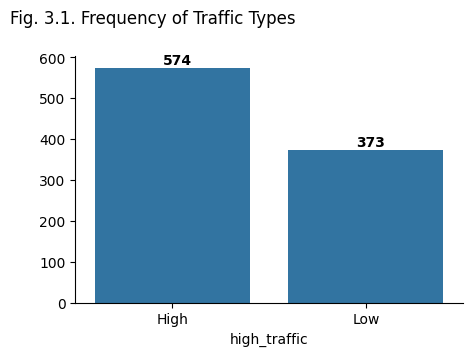

In [18]:
fig, ax = plt.subplots(figsize=(5, 3.2))

traffic_counts = df['high_traffic'].value_counts().values

sns.countplot(data=df,
              x='high_traffic',
              ax=ax)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

ax.text(-0.05, traffic_counts[0] + 10, f'{traffic_counts[0]}', fontweight='bold')
ax.text(0.95, traffic_counts[1] + 10, f'{traffic_counts[1]}', fontweight='bold')
ax.set_title('Fig. 3.1. Frequency of Traffic Types', y=1.1, x=0.2)
ax.set_ylabel(None)

plt.show()

Next, let's visualize the frequency of the recipe categories with bar plots.

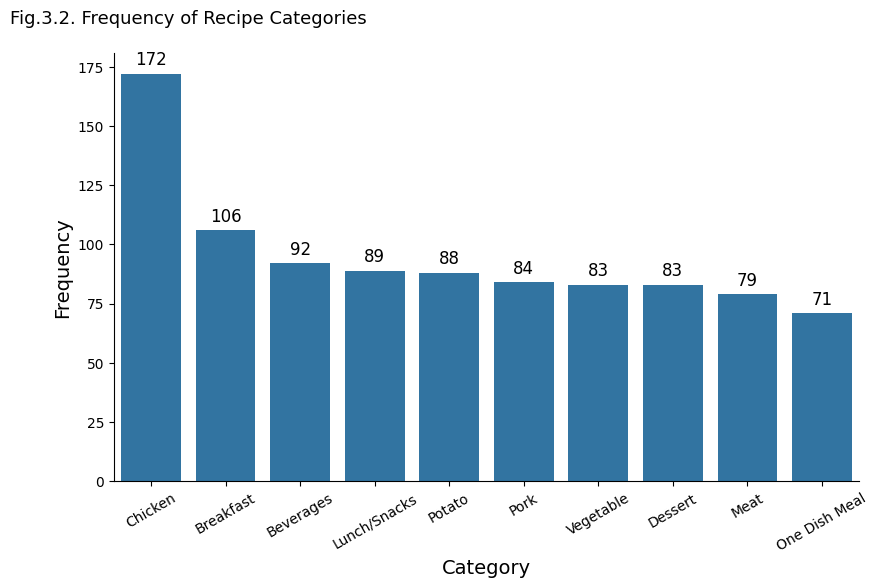

In [19]:
# Increase the size of the plot
fig, ax = plt.subplots(figsize=(8.5, 6))

category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

sns.barplot(x='category', y='count', ax=ax, data=category_counts)

# Customize the appearance
ax.set_title('Fig.3.2. Frequency of Recipe Categories', fontsize=13, y=1.05, x=0.1)
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
plt.xticks(rotation=30)

# Annotate each bar with the count
for patch in ax.patches:
    ax.annotate(f'{int(patch.get_height())}',
                (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                va='center',
                ha='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

# Remove the top and right spines
sns.despine()

plt.tight_layout()
plt.show()

Below, we find that all predictive features, except `servings`, are heavily skewed to the right. There are so many outliers. This is worth exploring further.

In [20]:
def create_histograms(df, fig_number=1):
    # Columns to plot
    dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']

    # Create the figure and specify GridSpec
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 3, figure=fig)

    # Create the subplots array using a shared grid
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]  # Top row (3 plots)
    axes += [fig.add_subplot(gs[1, 0]),  # First plot in bottom row
             fig.add_subplot(gs[1, 1:])]  # Last plot spans 2 columns

    # Plot each histogram
    for i, col in enumerate(dist_columns):
        sns.histplot(data=df, x=col, ax=axes[i], kde=True, edgecolor='black')
        skewness = skew(df[col].dropna())
        axes[i].set_title(f'{col}, skewness = {round(skewness, 2)}', fontsize=10)
        axes[i].set_ylabel('Frequency')

    fig.suptitle(f'Fig.{fig_number}. Distribution of Features', fontweight='semibold')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

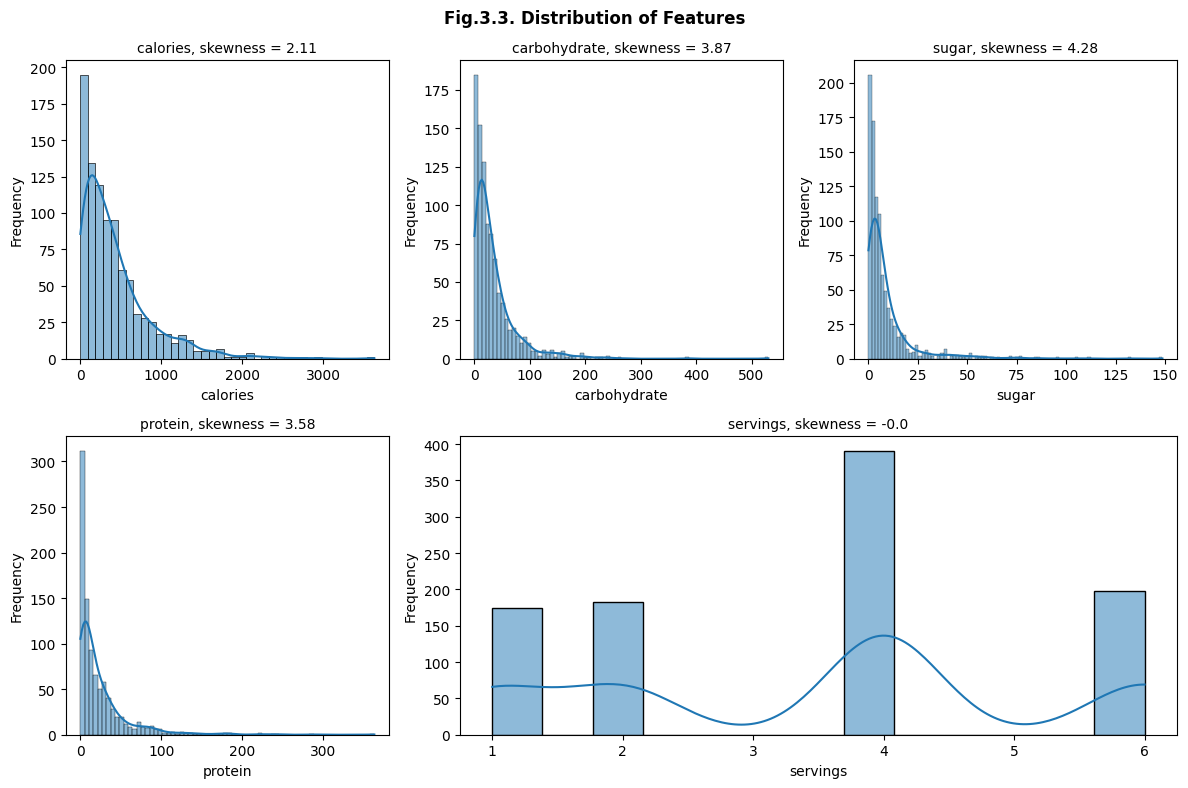

In [21]:
create_histograms(df, fig_number='3.3')

We can overlay boxplots of these distributions with a stripplot. The outliers become more visible.

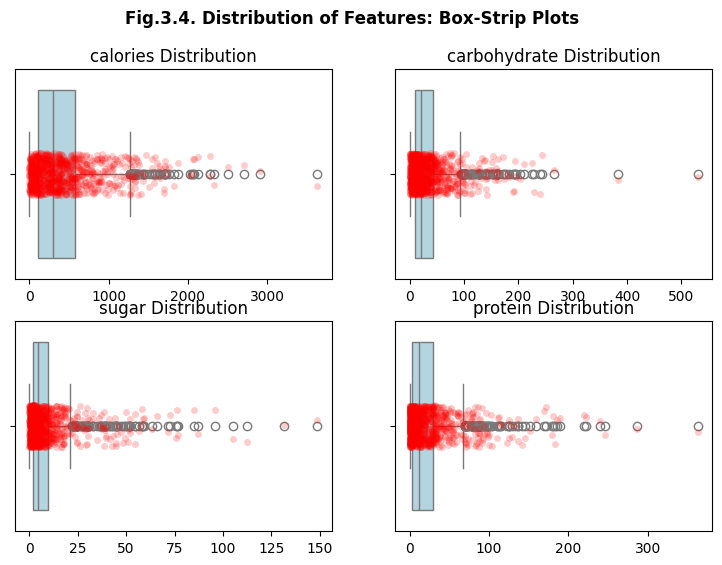

In [22]:
# Create subplots for four axes (1 row, 4 columns)
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
fig.suptitle('Fig.3.4. Distribution of Features: Box-Strip Plots', fontweight='semibold')

# List of variable names for easier loop usage
dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create boxplot and stripplot on each axis
for col, ax in zip(dist_columns, axes.ravel()):
    sns.boxplot(data=df, x=col, ax=ax, color='lightblue')
    sns.stripplot(data=df, x=col, ax=ax, color='red', jitter=True, alpha=0.2)

    ax.set_title(f'{col} Distribution')
    ax.set_xlabel('')

# Display the plots
plt.show()

#### Pairplot Relationships
The pairplot below shows there isn't any strong, or even moderate linear relationship between our predictive features. This is corroborated by the correlation heatmap in figure 3.6. The KDE plots on the other hand reiterate what we've already known: there are more high traffic recipes. However, it isn't really clear how far the right tails of each recipe category extends.

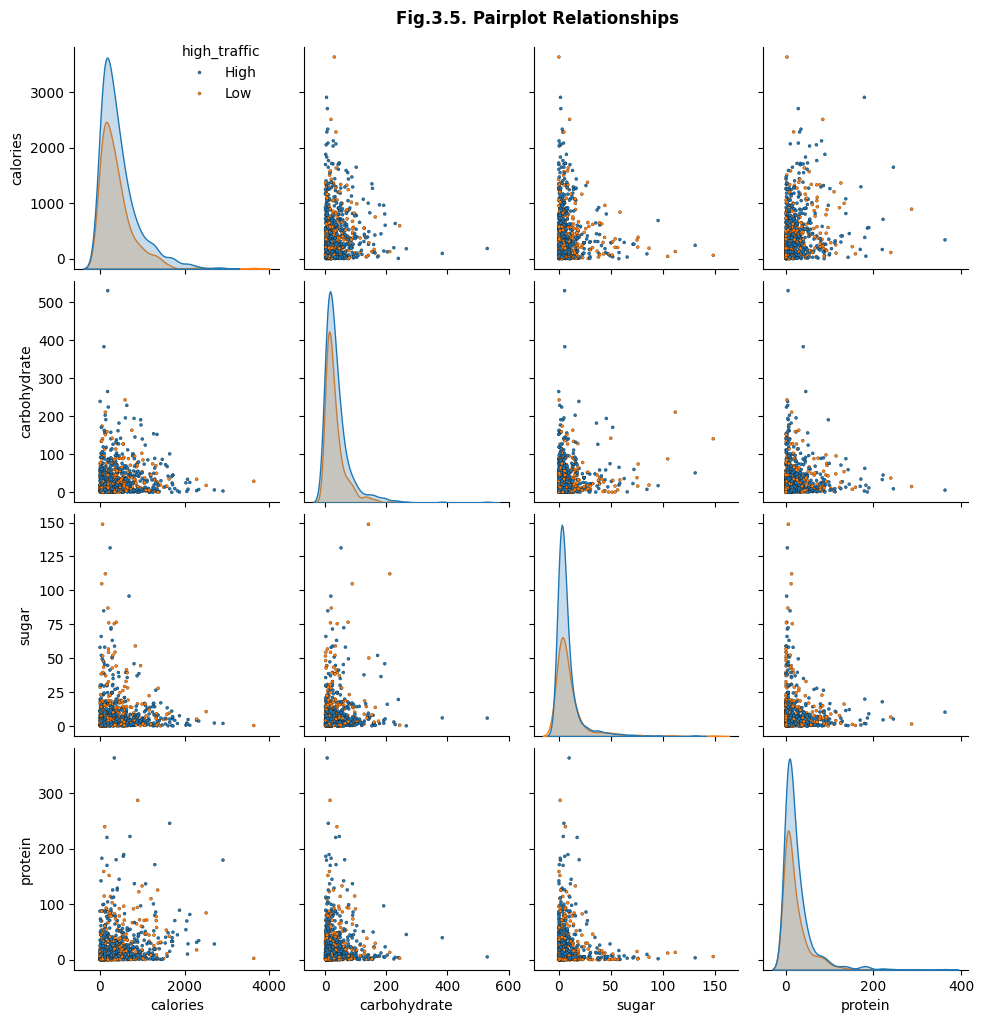

In [23]:
g = sns.pairplot(data=df.drop(['category', 'servings'], axis=1),
                 hue='high_traffic',
                 plot_kws=dict(edgecolor='black', s=5))
g.fig.suptitle('Fig.3.5. Pairplot Relationships', y=1.02, fontweight='semibold')
g._legend.set_bbox_to_anchor((0.25, 0.95))

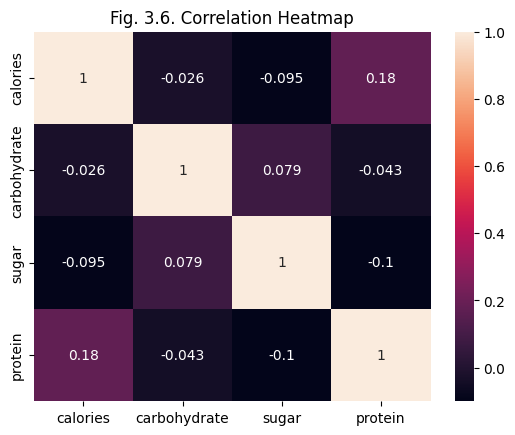

In [24]:
corr_df = df.drop(columns=['category', 'high_traffic', 'servings']).corr()
sns.heatmap(corr_df, annot=True)
plt.title('Fig. 3.6. Correlation Heatmap');

We can now explore boxplots of each numeric feature by traffic type. As shown in the figure below, it seems high traffic recipes have relatively higher amounts of calories, carbohydrate, and protein. Although the differences are not that significant.

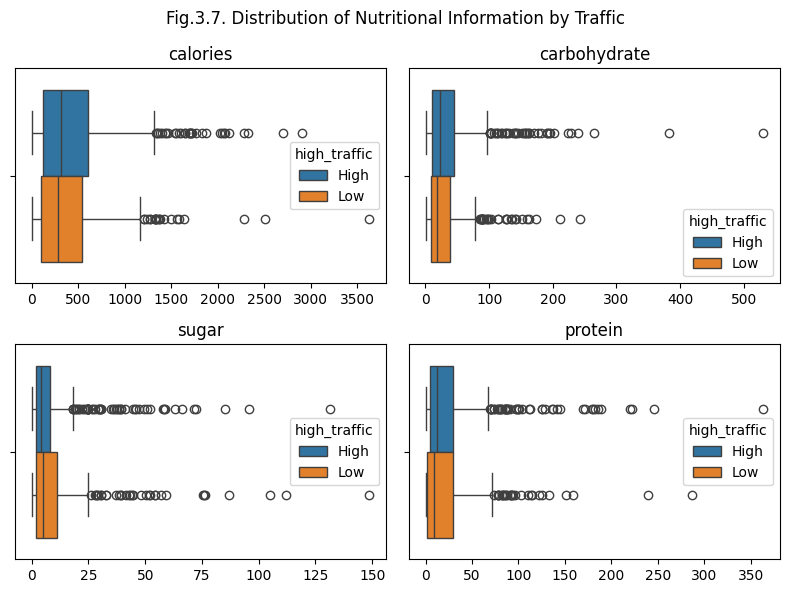

In [25]:
# Create subplots for four axes (1 row, 4 columns)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# List of variable names for easier loop usage
dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create boxplot and stripplot on each axis
for col, ax in zip(dist_columns, axes.ravel()):
    sns.boxplot(data=df, x=col, hue='high_traffic', ax=ax)
    ax.set_title(f'{col}')
    ax.set_xlabel('')

# Adjust layout to prevent overlap
fig.suptitle('Fig.3.7. Distribution of Nutritional Information by Traffic')
plt.tight_layout()
# plt.savefig('Fig.3.7. Distribution of Nutritional Information by Traffic.jpg', dpi=220, bbox_inches='tight')

# Display the plots
plt.show()

In what might be the most interesting finding so far, the recipe category seems to be a strong predictor of how much engagement a recipe will generate.

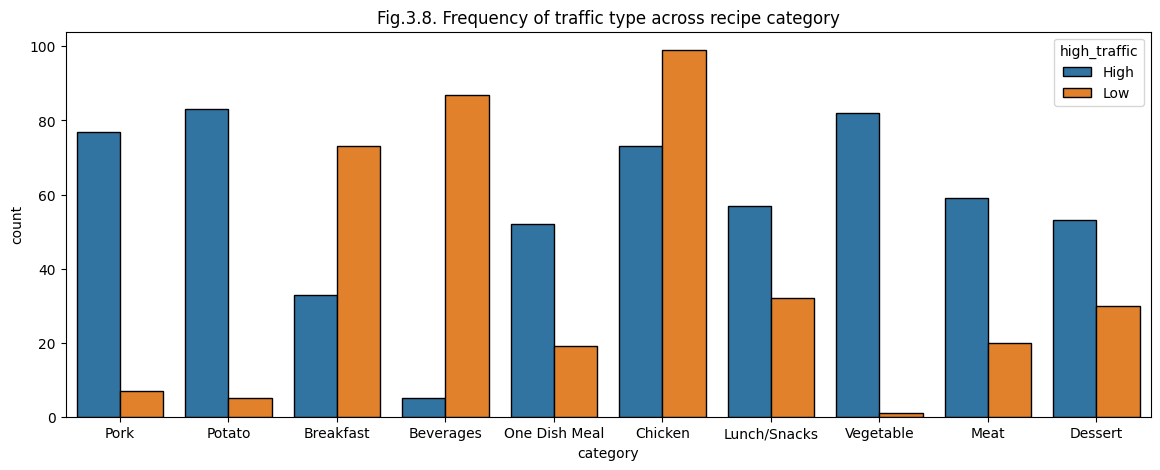

In [26]:
plt.figure(figsize=(14, 5))
sns.countplot(data=df, x='category', hue='high_traffic', edgecolor='black')
plt.title('Fig.3.8. Frequency of traffic type across recipe category')
# plt.savefig('Fig.3.8. Frequency of traffic type across recipe category.jpg', dpi=150, bbox_inches='tight')
plt.show();

Finally, the plots below showcase boxplots of the four nutrional variables across all the recipe categories and traffic types.

In [27]:
def create_boxplots_for_recipe_categories(df, column_name):
    """
    Create 10 boxplots (2x5 grid) for the specified column against the 'high_traffic' hue.

    Parameters:
        df (DataFrame): The dataframe containing the data.
        column_name (str): The name of the column to use for the y-axis.
    """

    # Create a figure with 5 rows and 2 columns of subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

    categories = ['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken',
                  'Lunch/Snacks','Vegetable','Meat','Dessert']

    # Loop through each subplot axis
    for category, ax in zip(categories, axes.ravel()):
        to_plot = df[df['category'] == category]
        sns.boxplot(data=to_plot, y=column_name, x='high_traffic', hue='high_traffic',
                    order=['High', 'Low'], hue_order=['High', 'Low'], ax=ax)
        sns.despine()
        ax.set_title(f'{category}')
        ax.set_xlabel('')
        ax.set_ylabel(column_name)

    fig.subplots_adjust(hspace=0.25)
    return fig

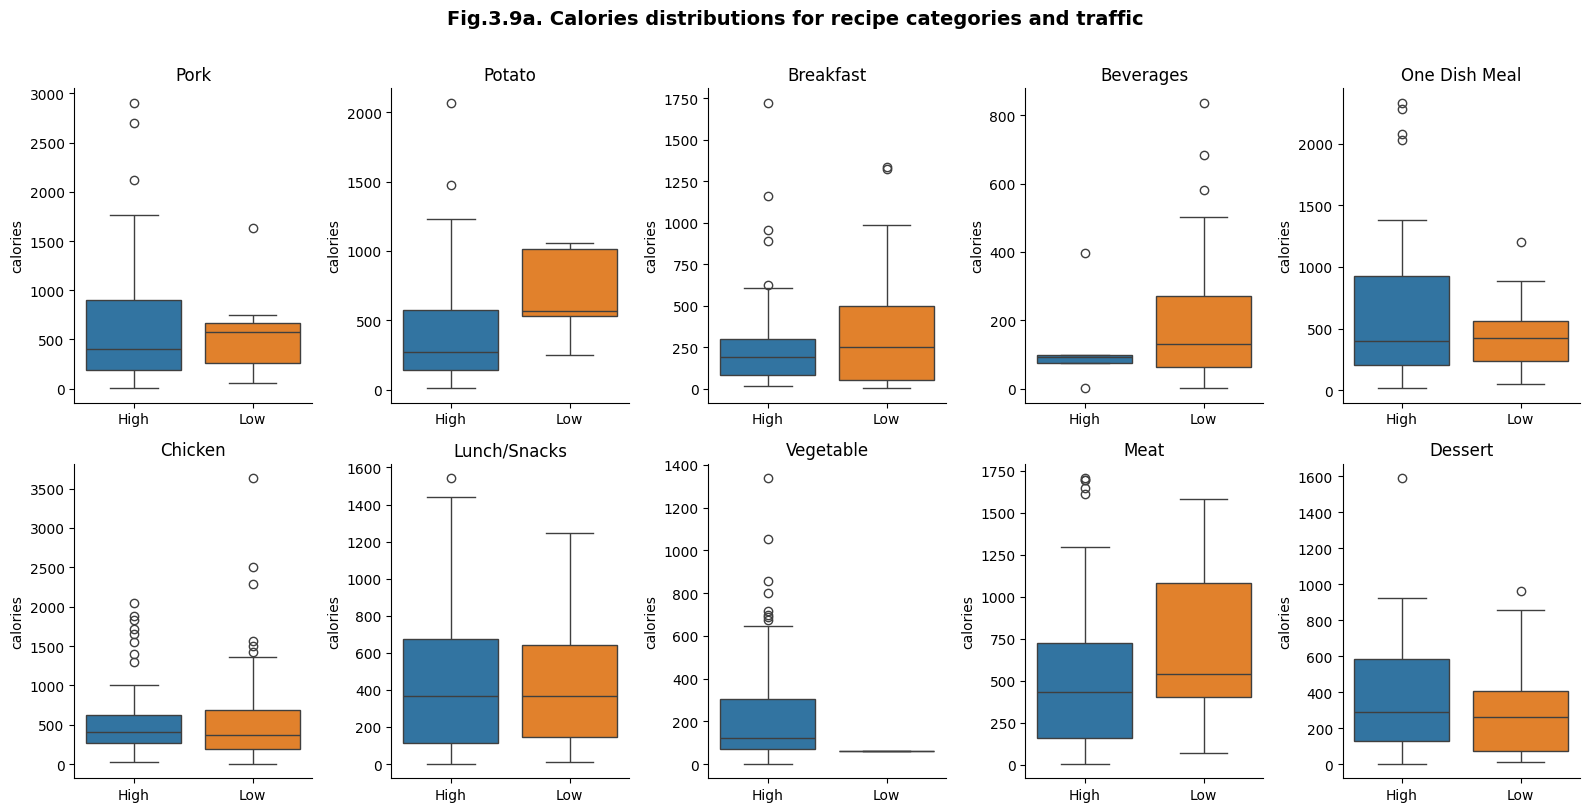

In [28]:
column_name = 'calories'
fig = create_boxplots_for_recipe_categories(df, column_name=column_name)
fig.suptitle(f'Fig.3.9a. {column_name.capitalize()} distributions for recipe categories and traffic',
             fontsize=14,
             fontweight='semibold',
             y=1.01)

plt.tight_layout()
plt.show()

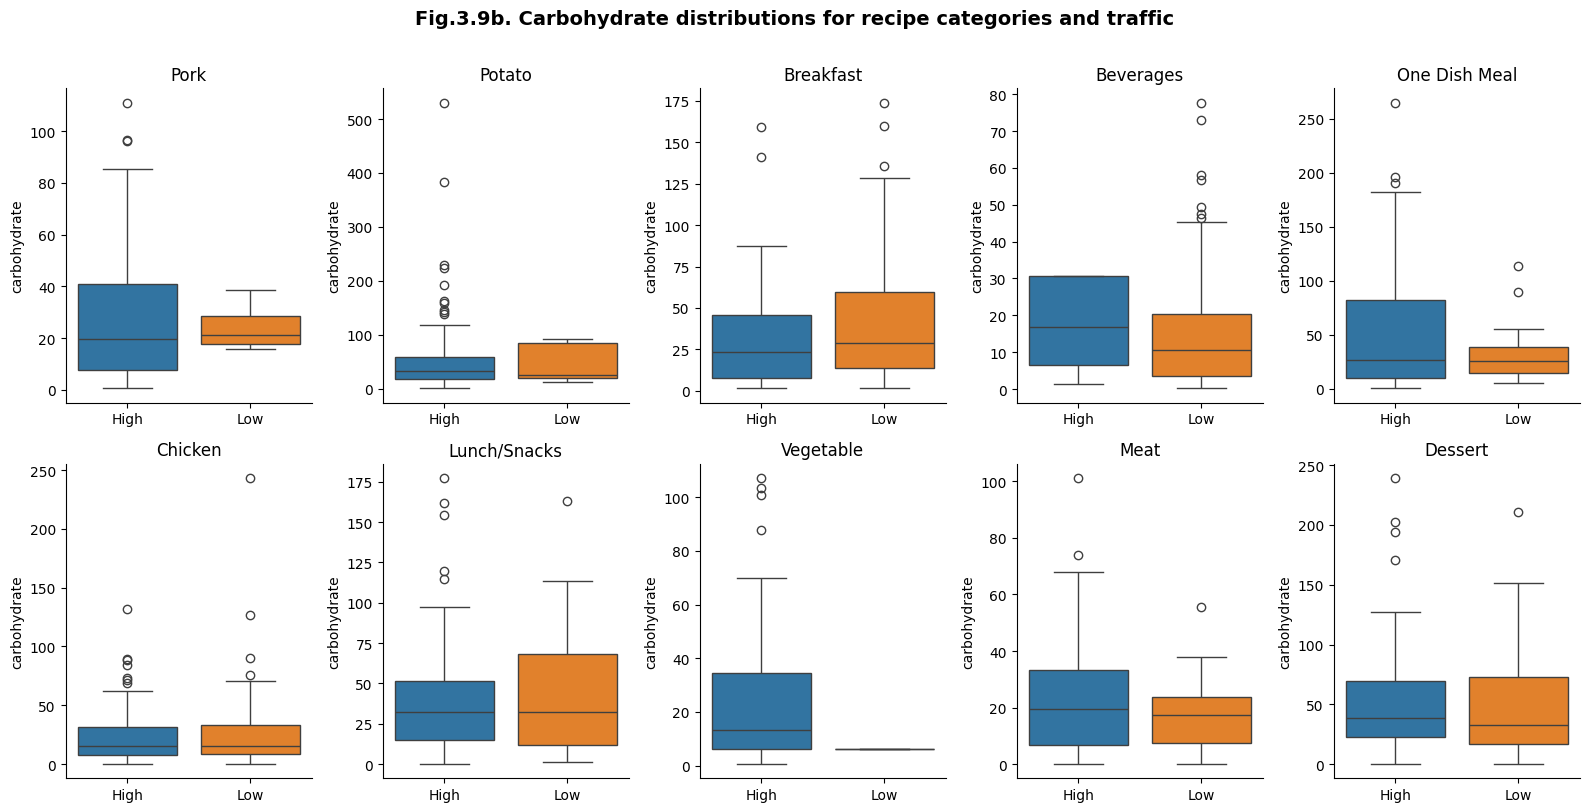

In [29]:
column_name = 'carbohydrate'
fig = create_boxplots_for_recipe_categories(df, column_name=column_name)
fig.suptitle(f'Fig.3.9b. {column_name.capitalize()} distributions for recipe categories and traffic',
             fontsize=14,
             fontweight='semibold',
             y=1.01)

plt.tight_layout()
plt.show()

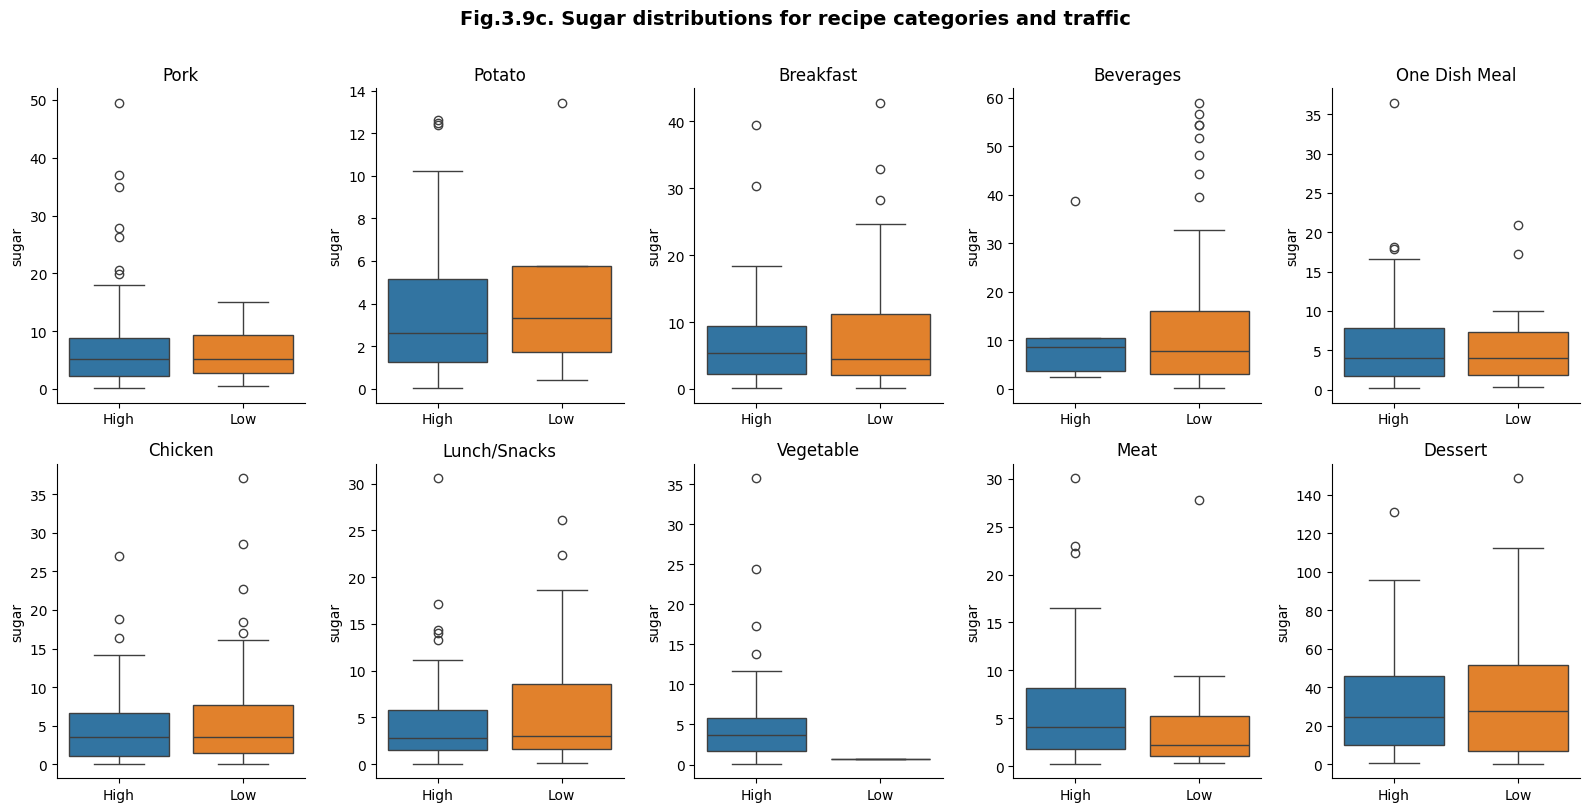

In [30]:
column_name = 'sugar'
fig = create_boxplots_for_recipe_categories(df, column_name=column_name)
fig.suptitle(f'Fig.3.9c. {column_name.capitalize()} distributions for recipe categories and traffic',
             fontsize=14,
             fontweight='semibold',
             y=1.01)

plt.tight_layout()
plt.show()

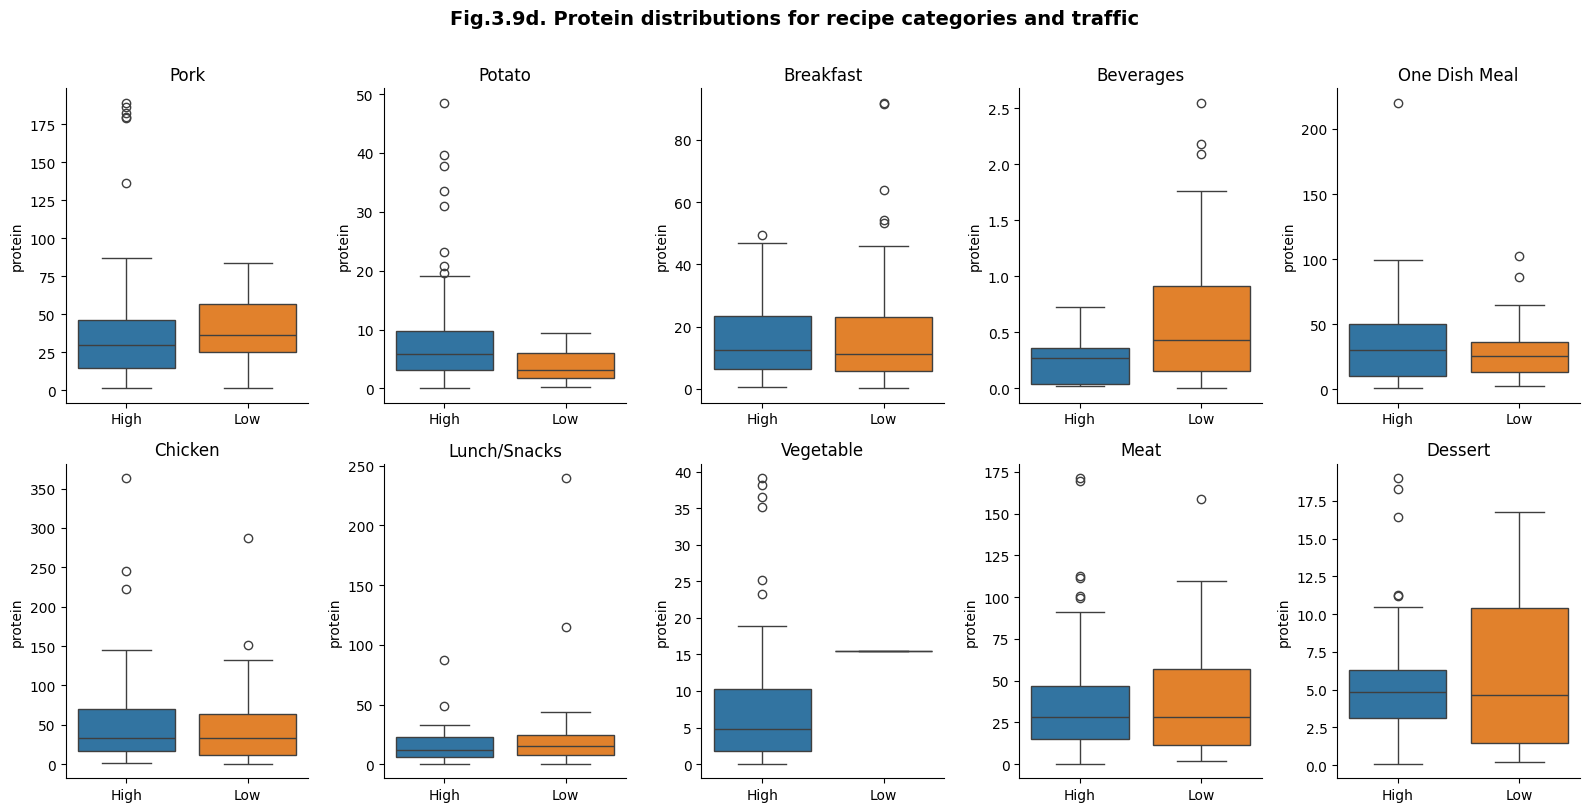

In [31]:
column_name = 'protein'
fig = create_boxplots_for_recipe_categories(df, column_name=column_name)
fig.suptitle(f'Fig.3.9d. {column_name.capitalize()} distributions for recipe categories and traffic',
             fontsize=14,
             fontweight='semibold',
             y=1.01)

plt.tight_layout()
plt.show()

### EDA Summary
- **Outliers and Skewness:** Nutritional data is heavily skewed to the right. To address this, options include removing outliers, transforming the data, or simply creating a new feature by flagging a recipe as an outlier or not.  
- **Correlation:** There is a small correlation (0.17) between `calories` and `protein`, which is expected since higher-protein foods often have more calories. However, this correlation is too small to be significant and can be ignored.  
- **Nutritional Information:** Popular recipes generally have higher median values for most nutritional metrics, except for sugar, where the difference is very small.  
- **Recipe Category:** Recipe category stands out as a strong predictor of popularity due to its clear association with recipe performance.  
- **Surprising Sugar Content in Pork Recipes:** Boxplots of nutritional information across recipe categories and traffic types look valid, though it’s surprising to see that Pork recipes have relatively and unexpectedly high sugar content.

## 4. Feature Engineering
This code implements a couple of feature engineering steps to prepare the recipe data for modeling. The first function helps to convert the nutritional columns into total values by multiplying the number of servings by each nutritional data. The original columns are then dropped, leaving only the total-nutritional data.

The second function helps to identify outliers in the carbohydrate, sugar, protein, and calories columns using Z-scores. A row is flagged as an outlier if the absolute Z-score in any of these columns exceeds 2. The number of columns for which the data point is considered an outlier is then stored in a new feature, `n_outliers`.



In [32]:
def get_total_nutritions(df):
    df = df.copy()
    col_names = ['calories', 'carbohydrate', 'sugar', 'protein']
    total_nut = ['total_' + col_name for col_name in col_names]

    df[total_nut] = df[col_names].mul(df['servings'], axis='index')
    df = df.drop(columns=col_names)

    return df


def detect_outliers(train_data, test_data, z_threshold=2):
    columns = ['calories', 'carbohydrate', 'protein', 'sugar']
    if 'total_protein' in train_data.columns:
        columns = ['total_' + c for c in columns]

    # Calculate means and standard deviations from the training data
    train_means = train_data[columns].mean()
    train_stds = train_data[columns].std()

    # Calculate Z-scores for the train and test data based on training data stats
    train_z_scores = (train_data[columns] - train_means) / train_stds
    test_z_scores = (test_data[columns] - train_means) / train_stds

    # Count the number of columns where the Z-score exceeds the threshold
    train_data['n_outliers'] = (train_z_scores.abs() > z_threshold).sum(axis=1)
    test_data['n_outliers'] = (test_z_scores.abs() > z_threshold).sum(axis=1)

    return train_data, test_data

In [33]:
df = clean_recipe(recipe, impute_by=None, remove_outliers=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int32  
 6   high_traffic  947 non-null    object 
dtypes: float64(4), int32(1), object(2)
memory usage: 48.2+ KB


## 5. Model Development
This is a **classification problem** in which we desire to predict what kind of traffic (High or Low) a recipe will generate when displayed on the company's website. As such, the objective in this section is to develop a predictive model that best captures the patterns in the data and meets performance requirements (or is at least close to it). To this effect, we will build, tune, and evaluate two models: a Logistic Regression model and a Random Forest model.

First, we will split our data into train and test sets for training and evaluating the model respectively, ensuring the original split of the target variable is preserved in both sets.

We will then write a function to impute both sets separately, using statistics from the training data. This is to avoid any form of data leakage.

In [34]:
def create_train_test(dataframe, test_size=0.2, random_state=42):

    # create features and target data
    X = dataframe.drop(columns='high_traffic')
    y = dataframe['high_traffic'].map({'High': 1, 'Low': 0})

    # create train and test data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        stratify=y,
                                                        random_state=random_state)

    return X_train, X_test, y_train, y_test

def impute_data(X_train, X_test, impute_by='category_mean'):
  cols = ['calories', 'carbohydrate', 'sugar', 'protein']

  # Compute imputation statistics using only the training set
  X_train.loc[:, cols] = X_train.groupby(by='category')[cols].transform(impute_by.split('_')[-1])

  stats = X_train[cols].mean().to_dict() if impute_by == 'category_mean' else X_train[cols].median().to_dict()
  X_test.loc[:, cols] = X_test.loc[:, cols].fillna(stats)

  return X_train, X_test

### 5.1. One-feature Model with Recipe Category
Here we'll focus on using only the `category` feature to build our predictive model. Later on, other features will be incorporated.

In [35]:
# create train and test splits, incorporate all rows in the data
X_train, X_test, y_train, y_test = create_train_test(df[['category', 'high_traffic']], test_size=0.2)

print(X_train.shape, X_test.shape)

(757, 1) (190, 1)


#### 5.1.1. Baseline Model-1: Logistic regression with `category` feature

In [36]:
# Define model components
encoder = OneHotEncoder(use_cat_names=True)
log_reg = LogisticRegression(random_state=42)

# Create pipeline
logr = Pipeline([
    ('ohe', encoder),
    ('estimator', log_reg)
])

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
cv_scores = cross_val_score(logr, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f"K-Fold Cross-Validation Results:\n{'='*30}")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# Train on full training set and evaluate on test set
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_pred = logr.predict(X_test)

# Print final evaluation
print("\nFinal Model Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

K-Fold Cross-Validation Results:
Accuracy Scores: [0.72368421 0.78947368 0.72847682 0.7615894  0.78807947]
Mean Accuracy: 75.83%
Standard Deviation: 2.81%

Final Model Evaluation:
Train Accuracy: 75.83%
Test Accuracy: 77.89%
              precision    recall  f1-score   support

           0       0.69      0.79      0.74        75
           1       0.85      0.77      0.81       115

    accuracy                           0.78       190
   macro avg       0.77      0.78      0.77       190
weighted avg       0.79      0.78      0.78       190



The logistic regression model with one feature performs with an accuracy of approximately **78%** on the test set. This is just 2% points lower than the target of 80%. The model does quite well in predicting high traffic recipes (**85%** precision and **77%** recall) but struggles with identifying the low traffic recipes. We might be able to build a better predictive model with the incorporation of additional features.

The confusion matrix below breaks down our model's performance. It seems to be predicting more of Class 0 (Low traffic) for recipes that are actually belong to Class 1 (High traffic) -- which makes the precision for class 0 lower.

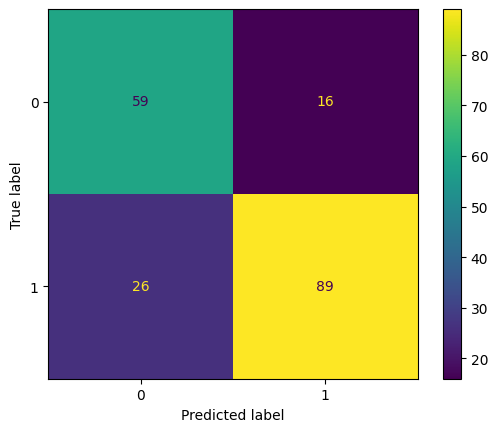

In [37]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot();

The figure below shows the odds ratio for the model. Features with **odds ratio greater than 1** increase the likelihood of the recipe generating high traffic and vice versa.

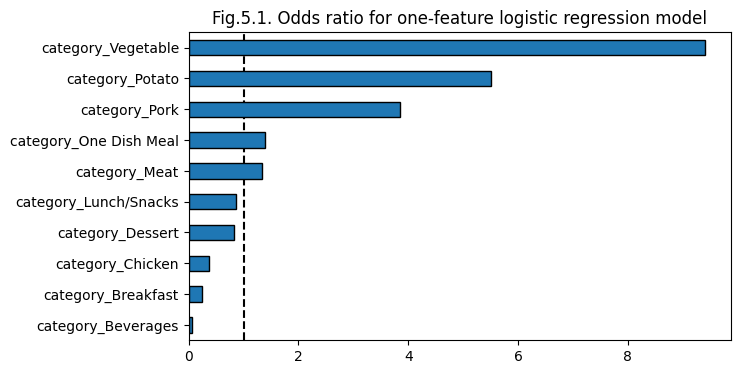

In [38]:
features = log_reg.feature_names_in_
odds_ratio = np.exp(log_reg.coef_[0])

plt.figure(figsize=(7, 4))
plt.axvline(1, color='black', linestyle='dashed', zorder=1)
pd.Series(odds_ratio, index=features).sort_values(ascending=True)\
                                     .plot(kind='barh',
                                           edgecolor='black',
                                           title='Fig.5.1. Odds ratio for one-feature logistic regression model')

plt.show();

#### 5.1.2. Comparison Model-1: Random Forest Classifier with `category` feature

In [39]:
# Define model components
encoder = OneHotEncoder(use_cat_names=True)
random_forest = RandomForestClassifier(random_state=42)

# Create pipeline
rfc = Pipeline([
    ('ohe', encoder),
    ('rfc', random_forest)
])

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
cv_scores = cross_val_score(rfc, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f"K-Fold Cross-Validation Results:\n{'='*30}")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# Train on full training set and evaluate on test set
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_pred = rfc.predict(X_test)

# Print final evaluation
print("\nFinal Model Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

K-Fold Cross-Validation Results:
Accuracy Scores: [0.72368421 0.78947368 0.72847682 0.7615894  0.78807947]
Mean Accuracy: 75.83%
Standard Deviation: 2.81%

Final Model Evaluation:
Train Accuracy: 75.83%
Test Accuracy: 77.89%
              precision    recall  f1-score   support

           0       0.69      0.79      0.74        75
           1       0.85      0.77      0.81       115

    accuracy                           0.78       190
   macro avg       0.77      0.78      0.77       190
weighted avg       0.79      0.78      0.78       190



The Random Forest model demonstrates reasonable performance with a test accuracy of **78%**, exactly the same results obtained with the logistic regression model. With one feature, both models behave quite similarly. Precision, recall, and F1-scores are also balanced across the classes, with Class 1 (High traffic) showing stronger performance. Further tuning and use of more features might improve results.

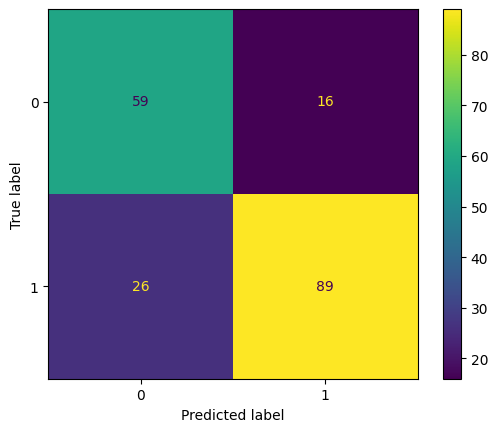

In [40]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot();

Below, we visualize the features that the model considered important in making its decisions.

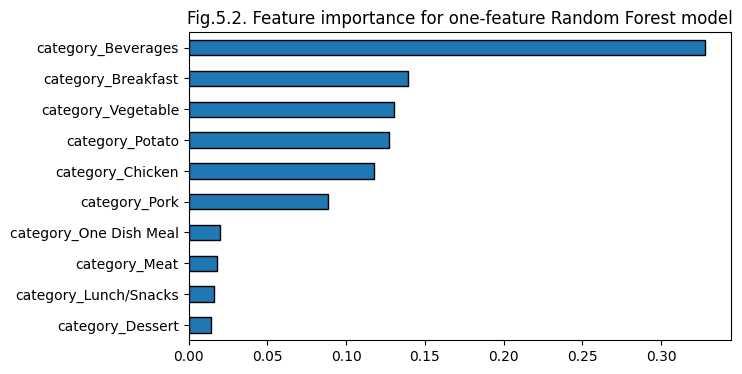

In [41]:
features = random_forest.feature_names_in_
importances = random_forest.feature_importances_

plt.figure(figsize=(7, 4))
pd.Series(importances, index=features).sort_values(ascending=True)\
                                      .plot(kind='barh',
                                            edgecolor='black',
                                            title='Fig.5.2. Feature importance for one-feature Random Forest model')
plt.show();

While the `category` feature has provided some predictive power, adding more features could capture additional patterns and interactions that can improve our model's performance. We anticipate that with a richer feature set, the Random Forest model in particular, may better demonstrate its ability to handle complex relationships and variability in the data.

### 5.2. Model Development with Multiple features
Here, we will build `Logistic Regression` and `RandomForest` models on all the features, while ensuring each nutritional information is converted to per-serving basis.

In [42]:
# split into train and test sets
X_train, X_test, y_train, y_test = create_train_test(df, test_size=0.20)

# impute data and incorporate new features
X_train, X_test = detect_outliers(*impute_data(X_train, X_test, impute_by='category_median'))
X_train = get_total_nutritions(X_train)
X_test = get_total_nutritions(X_test)

X_train.head()

,category,servings,n_outliers,total_calories,total_carbohydrate,total_sugar,total_protein
341,One Dish Meal,4,0,1613.740,101.02,16.000,106.48
508,Potato,1,0,268.035,31.84,2.725,5.97
281,Vegetable,4,0,532.500,51.20,11.940,17.94
258,Beverages,2,0,251.900,25.56,17.940,0.80
422,Pork,4,0,1541.740,77.32,20.640,127.60


#### 5.2.1. Baseline Model-2: Logistic Regression

In [43]:
# Define model components
encoder = OneHotEncoder(use_cat_names=True)
scaler = MinMaxScaler()
log_reg = LogisticRegression(random_state=42)

# Create pipeline
logr = Pipeline([
    ('ohe', encoder),
    ('scaler', scaler),
    ('estimator', log_reg)
])

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
cv_scores = cross_val_score(logr, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f"K-Fold Cross-Validation Results:\n{'='*30}")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# Train on full training set and evaluate on test set
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_pred = logr.predict(X_test)

# Print final evaluation
print("\nFinal Model Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

K-Fold Cross-Validation Results:
Accuracy Scores: [0.72368421 0.78947368 0.72847682 0.7615894  0.78807947]
Mean Accuracy: 75.83%
Standard Deviation: 2.81%

Final Model Evaluation:
Train Accuracy: 75.83%
Test Accuracy: 76.84%
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        75
           1       0.84      0.76      0.80       115

    accuracy                           0.77       190
   macro avg       0.76      0.77      0.76       190
weighted avg       0.78      0.77      0.77       190



The logistic regression model achieves an accuracy of approximately **77%** on the test set, a bit worse than the single-feature logistic regression model. The precision and recall scores for high traffic (or popular) recipes are still higher than the low traffic ones. Let's examine the confusion matrix.

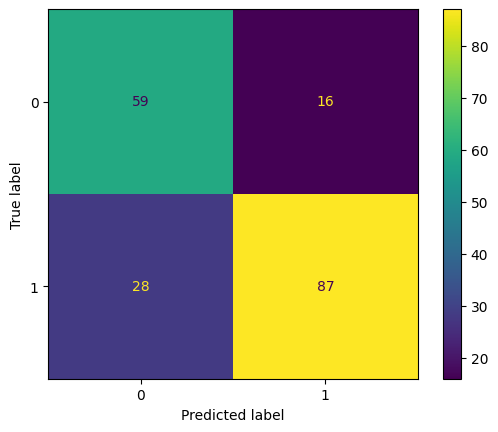

In [44]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot();

#### 5.2.2. Comparison Model-2: Random Forest Classifier
The Random Forest model with its default parameters achieves a **75.79%** accuracy on the test set. It, however, predicts more of class 1 for cases that actually belong to class 0, thereby diminishing the recall for class 0.

The model performs better on class 1 (F1-score: 0.81) than class 0 (F1-score: 0.68), indicating an imbalance in class performance that might need addressing through techniques like class weighting or hyperparameter tuning.

In [45]:
# Define model components
encoder = OneHotEncoder(use_cat_names=True)
random_forest = RandomForestClassifier(random_state=42)

# Create pipeline
rfc = Pipeline([
    ('ohe', encoder),
    ('rfc', random_forest)
])

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
cv_scores = cross_val_score(rfc, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f"K-Fold Cross-Validation Results:\n{'='*30}")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# Train on full training set and evaluate on test set
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_pred = rfc.predict(X_test)

# Print final evaluation
print("\nFinal Model Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

K-Fold Cross-Validation Results:
Accuracy Scores: [0.71052632 0.76973684 0.69536424 0.74172185 0.77483444]
Mean Accuracy: 73.84%
Standard Deviation: 3.15%

Final Model Evaluation:
Train Accuracy: 76.49%
Test Accuracy: 75.79%
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        75
           1       0.79      0.83      0.81       115

    accuracy                           0.76       190
   macro avg       0.75      0.74      0.74       190
weighted avg       0.76      0.76      0.76       190



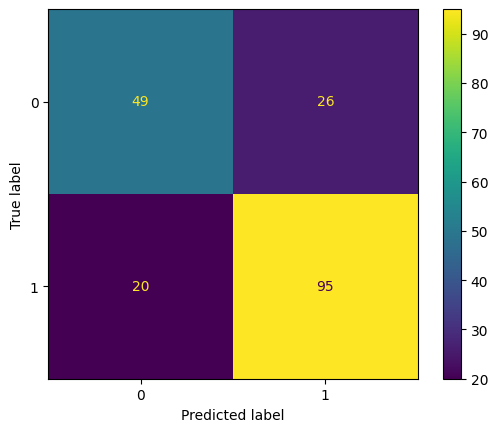

In [46]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot();

### 5.3. Hyperparameter Tuning

#### 5.3.1. Tuning Logistic Regression Hyperparameters
We'll focus on the `C` and `class_weight` hyperparameters to reduce overfitting and handle class imbalance respectively.

In [47]:
# Define the pipeline
pipeline = Pipeline([
    ('ohe', OneHotEncoder(use_cat_names=True)),
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Define the parameter grid for Logistic Regression
param_grid_pipeline = {
    'classifier__C': [0.1, 0.3, 1, 3],
    'classifier__class_weight': [None, 'balanced'],
}

# Set up GridSearchCV
grid_search_pipeline = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_pipeline,
    scoring='f1_macro',  # Optimize for macro F1-score
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV
grid_search_pipeline.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search_pipeline.best_params_)
print("Best F1 Score:", grid_search_pipeline.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'classifier__C': 0.3, 'classifier__class_weight': None}
Best F1 Score: 0.7447025732979429


In [48]:
tuned_lr = grid_search_pipeline.best_estimator_

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
cv_scores = cross_val_score(tuned_lr, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f"K-Fold Cross-Validation Results:\n{'='*30}")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# Train on full training set and evaluate on test set
tuned_lr.fit(X_train, y_train)
y_train_pred = tuned_lr.predict(X_train)
y_pred = tuned_lr.predict(X_test)

# Print final evaluation
print("\nFinal Model Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

K-Fold Cross-Validation Results:
Accuracy Scores: [0.72368421 0.78947368 0.72847682 0.7615894  0.78807947]
Mean Accuracy: 75.83%
Standard Deviation: 2.81%

Final Model Evaluation:
Train Accuracy: 75.83%
Test Accuracy: 76.84%
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        75
           1       0.84      0.77      0.80       115

    accuracy                           0.77       190
   macro avg       0.76      0.77      0.76       190
weighted avg       0.78      0.77      0.77       190



#### 5.3.2. Tuning the Random Forest Classifier
The hyperparameter search here is performed using RandomizedSearchCV to explores the following parameters: `n_estimators`, `max_depth` and `min_samples_leaf`. The macro F1-score will be optimized through 3-fold cross-validation.

In [49]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('ohe', OneHotEncoder(use_cat_names=True)),
    ('classifier', rf)
])

param_grid_pipeline = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_leaf': [2, 3, 4],
}

# Set up RandomizedSearchCV for the pipeline
grid_search_pipeline = GridSearchCV(estimator=pipeline,
                                    param_grid=param_grid_pipeline,
                                    scoring='f1_macro',
                                    cv=3,
                                    verbose=1,
                                    n_jobs=-1)

grid_search_pipeline.fit(X_train, y_train)
# Print the best parameters and score
print("Best Parameters:", grid_search_pipeline.best_params_)
print("Best F1 Score:", grid_search_pipeline.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}
Best F1 Score: 0.7229695078706033


In [50]:
tuned_rfr = grid_search_pipeline.best_estimator_

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
cv_scores = cross_val_score(tuned_rfr, X_train, y_train, cv=kf, scoring='accuracy')

# Print results
print(f"K-Fold Cross-Validation Results:\n{'='*30}")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# Train on full training set and evaluate on test set
tuned_rfr.fit(X_train, y_train)
y_train_pred = tuned_rfr.predict(X_train)
y_pred = tuned_rfr.predict(X_test)

# Print final evaluation
print("\nFinal Model Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

K-Fold Cross-Validation Results:
Accuracy Scores: [0.71052632 0.78289474 0.72847682 0.75496689 0.77483444]
Mean Accuracy: 75.03%
Standard Deviation: 2.74%

Final Model Evaluation:
Train Accuracy: 75.96%
Test Accuracy: 75.26%
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        75
           1       0.77      0.83      0.80       115

    accuracy                           0.75       190
   macro avg       0.74      0.73      0.74       190
weighted avg       0.75      0.75      0.75       190



### 5.4. Summary of Modelling Efforts and Model Selection
The one-feature Logistic Regression model demonstrated satisfactory performance with an overall accuracy of **77.89%**, effectively classifying instances and excelling at predicting Class 1 (High traffic recipes) with high precision and recall. Despite expectations, adding extra features did not enhance its performance (accuracy dropped to 76.84%).

Similarly, the Random Forest model achieved 77.89% accuracy with a single feature. However, when trained with multiple features, its accuracy dropped to **75.79%**. Hyperparameter tuning resulted in a slightly lesser accuracy of 75.26%. These accuracies are smaller, compared to any of the logistic regression models. Consequently, selecting Random Forest is unwarranted due to its lower performance.

While the single-feature Logistic Regression model appears optimal, it is worth acknowledging the potential contributions of additional features. Hence, we will select the multiple-feature Logistic Regression model with optimized hyperparameters. Evaluation of this model yields an accuracy of **76.84%**.

It is expected that in the face of more data and potentially more features, this model's performance would improve significantly.

In [51]:
# create categorical encoder and scaler
encoder = OneHotEncoder(use_cat_names=True)
scaler = MinMaxScaler()

# create logistic regression estimator with best hyperparameters
log = LogisticRegression(C=0.3,
                         class_weight=None,
                         penalty='l2',
                         solver='lbfgs',
                         random_state=42)

# create pipeline
logr = Pipeline([
    ('ohe', encoder),
    ('scaler', scaler),
    ('estimator', log)
])

# train pipeline and make predictions
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_pred = logr.predict(X_test)

# evaluate pipeline
test_report = classification_report(y_test, y_pred)
print(f"Model Accuracy\n===================")
print(f"Train set = {round(100 * accuracy_score(y_train, y_train_pred), 2)}%\
\nTest set = {round(100 * accuracy_score(y_test, y_pred), 2)}%")
print(test_report)

Model Accuracy
Train set = 75.83%
Test set = 76.84%
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        75
           1       0.84      0.77      0.80       115

    accuracy                           0.77       190
   macro avg       0.76      0.77      0.76       190
weighted avg       0.78      0.77      0.77       190



## 6. Conclusion  
The analysis has provided valuable insights into predicting website traffic levels, although there is potential for improvement with more data and features. The data was cleaned and validated by imputing missing nutritional values based on recipe categories and addressing formatting issues. EDA and feature engineering highlighted the importance of recipe categories in predicting traffic, and two models were trained—Logistic Regression and Random Forest. Logistic Regression (with optimized hyperparameters) outperformed Random Forest, achieving an accuracy of **76.84%**. Despite not meeting the target, the Logistic Regression model offered useful insights through its odds ratios, as shown below.

Categories such as `Vegetable`, `Potato`, and `Pork` increased the likelihood of higher traffic, while `Beverages`, `Chicken`, and `Breakfast` had the opposite effect. While the recipe category had a very strong influence on traffic, nutritional features had a moderate to low effect: protein, calories, and carbohydrates showed a moderate positive impact on traffic, while carbohydrates had the low negative impact. Overally, categorical features, especially food category, have a stronger impact on the target variable compared to nutritional or numerical features.

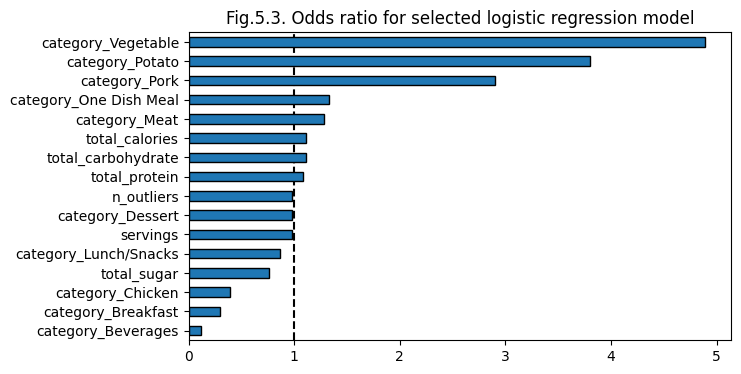

In [52]:
features = encoder.feature_names_out_
odds_ratio = np.exp(logr.named_steps['estimator'].coef_[0])

plt.figure(figsize=(7, 4))
plt.axvline(1, color='black', linestyle='dashed', zorder=1)
pd.Series(odds_ratio, index=features).sort_values(ascending=True)\
                                     .plot(kind='barh',
                                           edgecolor='black',
                                           title='Fig.5.3. Odds ratio for selected logistic regression model')
# plt.savefig('Fig.5.3. Odds ratio for selected logistic regression model.jpg', dpi=200, bbox_inches='tight')
plt.show();